In [ ]:
import matplotlib.colors as mcolors
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime, timedelta

"""
REF
    - https://plotly.com/python/plotly-express/
    - https://plotly.com/python/line-charts/
"""


def minmax_scaler(arr):
    """Scales a numpy array to the range [0, 1] using min-max normalization."""
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    # Handle the case where the range is zero (all values are the same)
    if arr_min == arr_max:
        return np.zeros_like(arr, dtype=float)
    return (arr - arr_min) / (arr_max - arr_min)


THRESHOLD = 90
samples = 101
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_linear_cmap",
    # ["#f04f0a"] * 10 + ["#e89e1e"] * 3 + ["#abb53f"] * 2 + ["#208c6f"],
    ["#f04f0a"] * 3 + ["#e89e1e"] * 1 + ["#abb53f"] * 1 + ["#208c6f"],
    N=samples,
)
values = [cmap(i)[:3] for i in minmax_scaler(np.logspace(0, 1, samples, base=10))]
RGB = [f"rgb({int(r * 255)},{int(g * 255)},{int(b * 255)})" for r, g, b in values]

data_samples = 100
start_dt = datetime(2025, 1, 1)
athlete_arr = ["me"] * data_samples
dt_arr = [start_dt + timedelta(days=i) for i in range(data_samples)]
score_arr = pd.Series(
    [i / (data_samples - 1) for i in range(data_samples)], dtype=pd.Float32Dtype()
)

DF = pd.DataFrame(
    {"Athlete": athlete_arr, "Overall Behavior Score": score_arr, "Dt": dt_arr}
)
DF["Date"] = DF["Dt"].apply(lambda x: datetime.strftime(x, "%m/%d/%Y"))

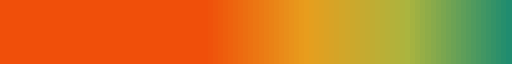

In [46]:
cmap

In [40]:
# import pickle

# with open("/Users/evelynstamey/ginnastix/data/attendance.pkl", "rb") as f:
#     df = pickle.load(f)
# df["Dt"] = df["Date"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

In [77]:
def get_color(x):
    if not x >= 0:
        return "#000000"
    if x >= THRESHOLD:
        return "#b3b3b3"
    if x < THRESHOLD:
        return "#ff9d73"


def update_stats_box(df, column_name):
    student_mean = df[column_name].mean()
    stat = int(round(student_mean * 100, 0))
    return f"{stat}%", RGB[stat]


def get_overall_behavior_graph(value):
    if not value:
        return None
    dff = DF[DF["Athlete"] == value]
    dff = dff.sort_values(by="Dt").reset_index(drop=True)
    dff["Behavior Score (%)"] = dff["Overall Behavior Score"].apply(
        lambda x: np.round(x * 100, 2)
    )

    dff["bar_color"] = (
        dff["Behavior Score (%)"]
        .astype("Float64")
        .apply(lambda x: "rgb(0,0,0)" if not x >= 0 else RGB[int(x)])
    )
    dff["bar_color2"] = dff["Behavior Score (%)"].astype("Float64").apply(get_color)
    student_mean = dff["Overall Behavior Score"].mean()
    student_mean = int(round(student_mean * 100, 2))

    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=dff["Date"],
            y=dff["Behavior Score (%)"],
            marker={"color": dff["bar_color"]},
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=dff["Date"],
            y=[THRESHOLD] * dff.shape[0],
            mode="lines",
            line=dict(color="black", width=1, dash="dot"),
            name="Class Expectation (90%)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=dff["Date"],
            y=[student_mean] * dff.shape[0],
            mode="lines",
            line=dict(
                color="black" if student_mean >= THRESHOLD else "#f04f0a",
                width=2,
            ),
            name=f"Average Score ({student_mean}%)",
        )
    )

    min_date = dff["Dt"].min().strftime("%m/%d/%Y")
    max_date = dff["Dt"].max().strftime("%m/%d/%Y")
    fig.update_layout(
        title={
            "text": "Class Behavior",
            "subtitle": {"text": f"({min_date} to {max_date})"},
        },
        xaxis_title="Class Day",
        yaxis_title="Score (%)",
        xaxis={"showgrid": False, "showticklabels": False},
        height=400,
        yaxis_range=[-5, 105],
        yaxis={"tickvals": [0, 20, 40, 60, 80, 100]},
        bargap=0,
        bargroupgap=0,
    )
    return fig

In [80]:
get_overall_behavior_graph("me")